In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import glob
import re

holidays = [dt.date(2020,12,31),dt.date(2021,1,1),dt.date(2021,1,2), dt.date(2021,1,3), dt.date(2021,1,4), dt.date(2021,1,5), 
            dt.date(2021,1,6), dt.date(2021,1,7), dt.date(2021,1,8), dt.date(2021,1,9), dt.date(2021,1,10), dt.date(2021,2,22),
            dt.date(2021,2,23), dt.date(2021,3,8), dt.date(2021,5,3),dt.date(2021,5,4), dt.date(2021,5,5), dt.date(2021,5,6), 
            dt.date(2021,5,7), dt.date(2021,5,10), dt.date(2021,11,4), dt.date(2021,11,5), dt.date(2021,12,31),
            dt.date(2022,1,1),dt.date(2022,1,2), dt.date(2022,1,3), dt.date(2022,1,4), dt.date(2022,1,5), 
            dt.date(2022,1,6), dt.date(2022,1,7), dt.date(2022,1,8), dt.date(2022,1,9)]

def preprocess_dataframe(dataframe,tag):
    dataframe['Время звонка']=dataframe['Время звонка'].astype('str')
    dataframe['Время ожидания']=pd.to_timedelta(dataframe['Время ожидания'].astype('str'))
    dataframe['Время разговора']=pd.to_timedelta(dataframe['Время разговора'].astype('str'))
    
    dataframe=dataframe.groupby((dataframe[['Номер телефона']].isnull()==False).all(1).cumsum()).agg({'Время звонка': ' '.join, 'Номер телефона': 'first', 'Статус звонка': 'first',
                  'Время ожидания': 'first', 'Время разговора': 'first',
                  'Группа': 'first', 'Оператор': 'first'})
    
    dataframe['Время звонка']=dataframe['Время звонка'].apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S %Y-%m-%d 00:00:00'))
    dataframe['Дата звонка']=dataframe['Время звонка'].dt.date
    dataframe['День недели']=dataframe['Время звонка'].apply(lambda x: x.weekday())
    dataframe['Час звонка']=dataframe['Время звонка'].dt.hour
    dataframe['Время звонка']=dataframe['Время звонка'].dt.time
    
    dataframe['Время ожидания']=dataframe['Время ожидания'].apply(lambda x: x.total_seconds()/60)
    dataframe['Время разговора']=dataframe['Время разговора'].apply(lambda x: x.total_seconds()/60)
    
    dataframe['Тип']=tag
    dataframe['Оператор']= dataframe['Оператор'].replace({np.nan:None})
    if (tag=='vmk'):
        #tmp_df=dataframe[(dataframe['Группа']!='Общая')]
        #tmp_df2=dataframe[dataframe['Группа']=='Общая']
        
        if (dataframe['Дата звонка'].values[0] in holidays):
            dataframe=dataframe[(dataframe['Час звонка']>=8) & (dataframe['Час звонка']<14)]
        else:
            dataframe=dataframe[(dataframe['Час звонка']>=8) & (((dataframe['День недели']<5) & (dataframe['Час звонка']<18)) | ((dataframe['День недели']>=5) & (dataframe['Час звонка']<14)))]
        
        #dataframe=pd.concat([tmp_df,tmp_df2])
        #dataframe['Оператор']=dataframe['Оператор'].apply(lambda x: str(x)+' (vmk)' if not x is None else None)
    
    return dataframe

def calculate_statistics2(dataframe):
    tmp=dataframe[(dataframe['Тип']=='call_center') & (dataframe['Оператор'].notna()) & (dataframe['Статус звонка']!='Не дождался')]
    call_center_volont_day=len(tmp[(tmp['Час звонка']>=8) & (tmp['Час звонка']<18)]['Оператор'].unique())
    call_center_volont_night=len(tmp[(tmp['Час звонка']<8) | (tmp['Час звонка']>=18)]['Оператор'].unique())
    vmk_volont=len(dataframe[(dataframe['Тип']=='vmk') & (dataframe['Оператор'].notna()) & (dataframe['Статус звонка']!='Не дождался')]['Оператор'].unique())
    print(vmk_volont,call_center_volont_day)
    
    all_night_calls=dataframe[(dataframe['Час звонка']<8) | (dataframe['Час звонка']>=18)].shape[0]
    
    all_calls=dataframe.shape[0]
    missed_calls=dataframe[dataframe["Статус звонка"]=='Не дождался'].shape[0]
    mean_talk=np.round(dataframe['Время разговора'].mean(),1)
    max_wait=np.round(dataframe['Время ожидания'].max(),1)
    group_with_max_wait=dataframe[dataframe['Время ожидания']==dataframe['Время ожидания'].max()]['Группа'].values[0]
    time_with_max_wait=dataframe[dataframe['Время ожидания']==dataframe['Время ожидания'].max()]['Время звонка'].values[0]
    
    mean_wait=np.round(dataframe['Время ожидания'].mean(),1)
    more_3_min=dataframe[dataframe['Время ожидания']>=3].shape[0]
    to_doctor=dataframe[(dataframe['Группа']=='Медколледж') | (dataframe['Группа']=='Волжский')].shape[0]
    other=dataframe[dataframe['Группа']=='Облкомобразования'].shape[0]
    
    print('Число операторов всего: {0}'.format(call_center_volont_day+call_center_volont_night+vmk_volont))
    print('Число операторов днем: {0}'.format(call_center_volont_day+vmk_volont))
    print('Число операторов ночью: {0} (ночью позвонили {1} раз)'.format(call_center_volont_night,all_night_calls))
    
    print('Количество звонков по COVID-19: {0}'.format(all_calls))
    print('Неотвеченных вызовов, шт.: {0}'.format(missed_calls))
    print('Среднее время разговора (мин): {0}'.format(mean_talk))
    print('Максимальное время ожидания (мин): {0} ({1},{2})'.format(max_wait,group_with_max_wait,time_with_max_wait))
    print('Среднее время ожидания (мин): {0}'.format(mean_wait))
    print('Ожидание более 3 минут (%): {0}'.format(np.round(more_3_min*100/all_calls,0)))
    print('Запись к врачу (%): {0}'.format(np.round(to_doctor*100/all_calls,0)))
    print('Иное (%): {0}'.format(100-np.round(to_doctor*100/all_calls,0)))

names1 = glob.glob('../Недозвоны/Колл-центр COVID-19/*', recursive=True)
names2= glob.glob('../Недозвоны/ВМК/*', recursive=True)
names3= glob.glob('../Недозвоны/Волжский/*', recursive=True)
cont = []

for i in range(len(names1)):
    df = pd.read_excel(names1[i])
    df=preprocess_dataframe(df,'call_center')
    match = re.search(r'\d{4}-\d{2}-\d{2}', names1[i])
    df['Отчетная дата'] = dt.datetime.strptime(match.group(), '%Y-%m-%d').date()
    cont.append(df)
    
for i in range(len(names2)): 
    if names2[i]!='../Недозвоны/ВМК\~$2021-02-19.xlsx':
        
        #print(names2[i])
        df = pd.read_excel(names2[i])
        df=preprocess_dataframe(df,'vmk')
        match = re.search(r'\d{4}-\d{2}-\d{2}', names2[i])
        df['Отчетная дата'] = dt.datetime.strptime(match.group(), '%Y-%m-%d').date()
        cont.append(df)
    
for i in range(len(names3)):
    df = pd.read_excel(names3[i],usecols=['Дата вызова','Время вызова','Номер вызывающего','Статус'])
    df=df.rename(columns={'Дата вызова':'Дата звонка','Время вызова':'Время звонка','Статус':'Статус звонка','Номер вызывающего':'Номер телефона'})
    df['Время ожидания']=None
    df['Время разговора']=None
    df['Время ожидания']=df['Время ожидания'].astype('float')
    df['Время разговора']=df['Время разговора'].astype('float')
    df['Группа']='Волжский'
    df['Оператор']=None
    df['Время звонка']=pd.to_datetime(df['Время звонка'])
    df['Дата звонка']=pd.to_datetime(df['Дата звонка'])
    df['День недели']=df['Дата звонка'].apply(lambda x: x.weekday())
    df['Час звонка']=df['Время звонка'].dt.hour
    df['Тип']='vmk'
    df['Время звонка']=df['Время звонка'].dt.time
    df['Дата звонка']=df['Дата звонка'].dt.date
    
    if (df['Дата звонка'].values[0] in holidays):
        df=df[(df['Час звонка']>=8) & (df['Час звонка']<14)]
    else:
        df=df[(df['Час звонка']>=8) & (((df['День недели']<5) & (df['Час звонка']<18)) | ((df['День недели']>=5) & (df['Час звонка']<14)))]
    
    df['Статус звонка']=df['Статус звонка'].replace({'пропущенный':None,'успешный':None})
    match = re.search(r'\d{4}-\d{2}-\d{2}', names3[i])
    df['Отчетная дата'] = dt.datetime.strptime(match.group(), '%Y-%m-%d').date()
    cont.append(df)


total_all_days = pd.concat(cont)
total_all_days['Группа']=total_all_days['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования'})

In [2]:
#day=dt.date(2022,1,14)

day = dt.date.today()

calculate_statistics2(total_all_days[total_all_days['Отчетная дата']==day])

9 0
Число операторов всего: 9
Число операторов днем: 9
Число операторов ночью: 0 (ночью позвонили 0 раз)
Количество звонков по COVID-19: 709
Неотвеченных вызовов, шт.: 59
Среднее время разговора (мин): 1.8
Максимальное время ожидания (мин): 4.9 (Медколледж,08:02:07)
Среднее время ожидания (мин): 0.5
Ожидание более 3 минут (%): 4.0
Запись к врачу (%): 100.0
Иное (%): 0.0


In [3]:
# ------ conversion of time from seconds to hours:minutes:seconds -----------

total_all_days['После 8']=total_all_days['Время звонка'].apply(lambda x: (x.hour-8)*60*60+x.minute*60+x.second)
total_all_days = total_all_days.dropna()
total_all_days['Ждали']=total_all_days['Время ожидания'].apply(lambda x: x*60)
total_all_days['Ждали']= total_all_days.apply(lambda row: row['После 8'] if row['Ждали'] > row['После 8'] else row['Ждали'], axis=1)
total_all_days['Время ожидания звонка']=total_all_days['Ждали'].apply(lambda x: dt.time(int(x/3600), int((x-int(x/3600)*3600)/60), int(x-int(x/60)*60)))
# -----------------------------------------------------------------------------

total_all_days[total_all_days['Отчетная дата']==day].sort_values(by='Время ожидания', ascending=False)[['Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка']].head(20)
#table1 = total_all_days[total_all_days['Отчетная дата']==day].sort_values(by='Время ожидания', ascending=False)[['Дата звонка','Время звонка','Время ожидания', 'Группа', 'Оператор', 'Статус звонка']].head(150)
#table1.to_excel("Сортировка по времени ожидания.xlsx")

,Дата звонка,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
23,2022-01-20,08:02:07,00:02:07,Медколледж,user11,Завершён оператором
75,2022-01-20,08:10:52,00:04:36,Медколледж,user19,Завершён абонентом
49,2022-01-20,08:05:58,00:04:20,Медколледж,user11,Завершён оператором
48,2022-01-20,08:05:53,00:03:58,Медколледж,user10,Завершён оператором
29,2022-01-20,08:02:53,00:02:53,Медколледж,user10,Завершён оператором
58,2022-01-20,08:07:13,00:03:49,Медколледж,user5,Завершён оператором
53,2022-01-20,08:06:32,00:03:48,Медколледж,user13,Завершён оператором
80,2022-01-20,08:12:36,00:03:47,Медколледж,user14,Завершён оператором
90,2022-01-20,08:14:11,00:03:45,Медколледж,user10,Завершён абонентом
55,2022-01-20,08:06:41,00:03:43,Медколледж,user11,Завершён оператором


In [4]:
# ------------------------------------
# x =(2*60*60+28*60+17)
# print(x, int(x/3600), int((x-int(x/3600)*3600)/60), int(x-int(x/60)*60))
# select_user89 = total_all_days[(total_all_days['Отчетная дата']==dt.date(2021,11,2)) & ((total_all_days['Оператор']=='user8') | (total_all_days['Оператор']=='user9'))]
# select_user89['Группа']=select_user89['Группа'].replace({'Медколледж':'Образования', 'Ограничения':'Образования'})

# select_user89[['Время звонка','После 8','Время ожидания','Ждали','Время ожидания звонка','Оператор','Группа']]
boolean_condition_1 = (total_all_days['Группа'] == "Медколледж" )&(total_all_days['Отчетная дата']==dt.date(2021,11,2)) & ((total_all_days['Оператор']=='user8') | (total_all_days['Оператор']=='user9'))
# boolean_condition_1 = (total_all_days['Отчетная дата']==dt.date(2021,11,2)) & ((total_all_days['Оператор']=='user8') | (total_all_days['Оператор']=='user9'))

# total_all_days.loc[:,'Группа']
# total_all_days.loc[boolean_condition_1,['Группа'] ] = 'Образования'

total_all_days[['Время звонка','После 8','Время ожидания','Ждали','Время ожидания звонка','Оператор','Группа']]

,Время звонка,После 8,Время ожидания,Ждали,Время ожидания звонка,Оператор,Группа
1,17:08:12,32892,0.266667,16.0,00:00:16,user8,Облкомобразования
2,17:15:10,33310,0.266667,16.0,00:00:16,user2,Облкомобразования
3,17:15:37,33337,0.250000,15.0,00:00:15,user8,Облкомобразования
4,17:16:10,33370,1.666667,100.0,00:01:40,user8,Облкомобразования
5,17:21:36,33696,0.333333,20.0,00:00:20,user2,Облкомобразования
...,...,...,...,...,...,...,...
705,17:50:35,35435,0.883333,53.0,00:00:53,user12,Медколледж
706,17:52:26,35546,0.300000,18.0,00:00:18,user10,Медколледж
707,17:52:40,35560,0.033333,2.0,00:00:02,user11,Медколледж
708,17:55:09,35709,0.216667,13.0,00:00:13,user12,Медколледж


In [5]:
# -------------------------------

# select_user89.loc[(select_user89['Группа'] == "Образования",['Группа'])] = 'Медколледж'

# select_user89[['Время звонка','После 8','Время ожидания','Ждали','Время ожидания звонка','Оператор','Группа']]

# total_all_days.loc[total_all_days['Оператор']=="user8", :]
total_all_days.loc[boolean_condition_1,['Группа','Время ожидания звонка','Оператор']]
# total_all_days[['Оператор','Группа','Время ожидания звонка']]
# total_all_days[total_all_days['Отчетная дата']==day].sort_values(by='Время ожидания звонка', ascending=False)[['Дата звонка','Время звонка','Время ожидания звонка','Время ожидания', 'Группа', 'Оператор', 'Статус звонка']].head(20)
#.astype('str')
#total_all_days.dtypes

,Группа,Время ожидания звонка,Оператор
570,Медколледж,00:00:27,user8
581,Медколледж,00:00:06,user8
586,Медколледж,00:00:13,user8
589,Медколледж,00:00:31,user8
596,Медколледж,00:00:07,user8
601,Медколледж,00:00:26,user9
607,Медколледж,00:00:22,user9


In [6]:
df['Дата звонка']=pd.to_datetime(df['Дата звонка'])
df=df[(df['Дата звонка'] > '2021-01-01') & (df['Дата звонка'] < '2021-03-31')]
print (df)


Empty DataFrame
Columns: [Дата звонка, Время звонка, Номер телефона, Статус звонка, Время ожидания, Время разговора, Группа, Оператор, День недели, Час звонка, Тип, Отчетная дата]
Index: []


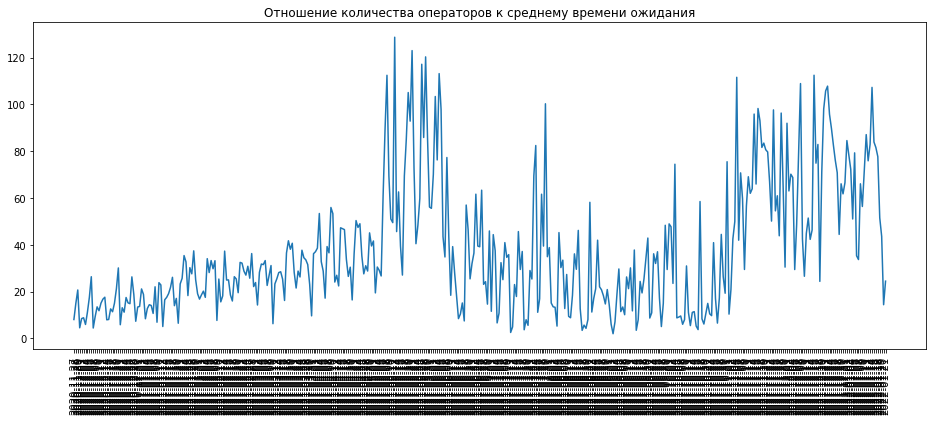

In [7]:
import matplotlib.pyplot as plt
temp = total_all_days.groupby('Отчетная дата').agg({'Оператор': ['nunique'],'Время ожидания':['mean']}).reset_index()
temp2 = total_all_days[total_all_days['Статус звонка']=='Не дождался'].groupby('Отчетная дата').agg({'Дата звонка':['count']}).reset_index()
temp=temp.merge(temp2)
temp.columns=temp.columns.droplevel(1)
temp.columns=['Дата','Количество операторов','Среднее время ожидания','Количество недозвонов']

f = plt.figure(figsize=(16,6))
#plt.plot(temp['Дата'], temp['Количество операторов']/temp['Количество недозвонов'])
plt.plot(temp['Дата'], temp['Количество операторов']/temp['Среднее время ожидания'])

#plt.title('Отношение количества операторов к количеству неотвеченных вызовов')
plt.title('Отношение количества операторов к среднему времени ожидания')

plt.rcParams.update({'font.size': 13})
plt.xticks(pd.date_range(start=temp['Дата'].min(), end=temp['Дата'].max()))
plt.gca().xaxis.set_tick_params(rotation = 90) 
plt.show()

f.savefig('Отношение количества операторов к среднему времени ожидания.png', dpi=600)

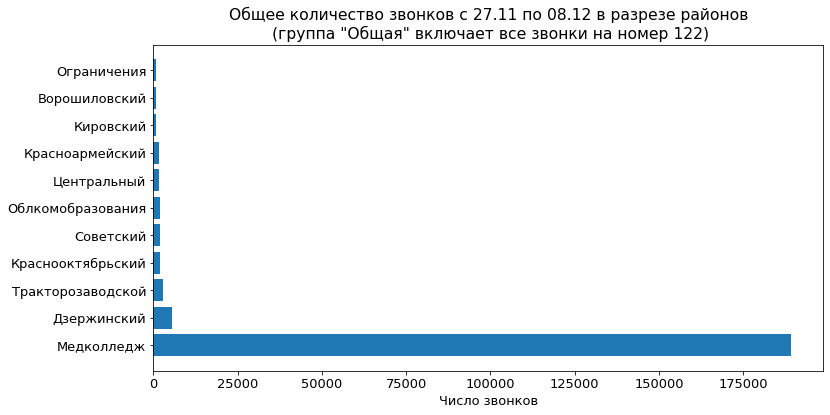

In [8]:
import matplotlib.pyplot as plt
tmp=total_all_days[total_all_days['Тип']=='vmk'].groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False)

f = plt.figure(figsize=(12,6))
plt.barh(tmp['Группа'], tmp['Число звонков'],label='Общее количество звонков')

plt.xlabel('Число звонков')
plt.title('Общее количество звонков с 27.11 по 08.12 в разрезе районов\n (группа "Общая" включает все звонки на номер 122)')

plt.rcParams.update({'font.size': 13})
plt.show()

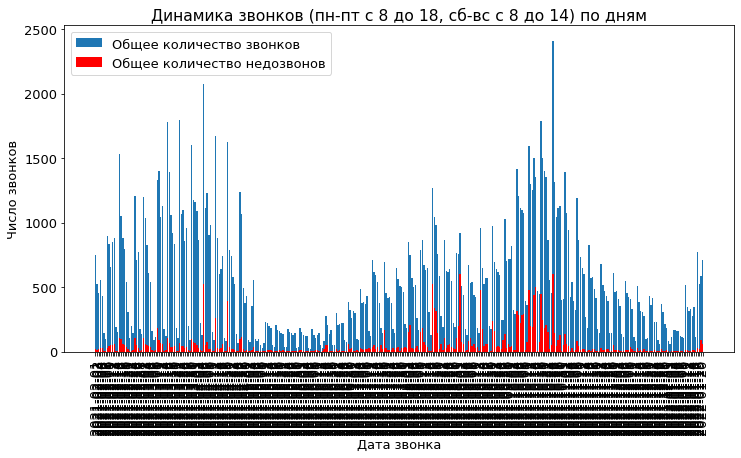

In [9]:
import matplotlib.pyplot as plt

#name='Медколледж'

tmp=total_all_days[(total_all_days['Дата звонка']>=dt.date(2021,2,1))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
tmp2=total_all_days [ (total_all_days['Статус звонка']=='Не дождался') & (total_all_days['Дата звонка']>=dt.date(2021,2,1))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")

f = plt.figure(figsize=(12,6))
plt.bar(tmp['Дата звонка'], tmp['Число звонков'],label='Общее количество звонков')
plt.bar(tmp2['Дата звонка'], tmp2['Число звонков'],label='Общее количество недозвонов',color='red')

plt.xlabel('Дата звонка')
plt.ylabel('Число звонков')
plt.title('Динамика звонков (пн-пт с 8 до 18, сб-вс с 8 до 14) по дням')

plt.xticks(pd.date_range(start=tmp['Дата звонка'].min(), end=tmp['Дата звонка'].max()))
plt.rcParams.update({'font.size': 13})
plt.gca().xaxis.set_tick_params(rotation = 90) 
plt.legend()
plt.show()

In [10]:
tmp=total_all_days[(total_all_days['Дата звонка']>=dt.date(2021,4,1)) & (total_all_days['Дата звонка']<=dt.date(2021,4,30))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
tmp2=total_all_days [ (total_all_days['Статус звонка']!='Не дождался') & (total_all_days['Дата звонка']>=dt.date(2021,4,1)) & (total_all_days['Дата звонка']<=dt.date(2021,4,30))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
Total = tmp2['Число звонков'].sum()

print(tmp2)
print(Total)


   Дата звонка  Число звонков
0   2021-04-01           1039
1   2021-04-02            841
2   2021-04-03            216
3   2021-04-04            126
4   2021-04-05           1555
5   2021-04-06           1061
6   2021-04-07           1153
7   2021-04-08            884
8   2021-04-09            964
9   2021-04-10            154
10  2021-04-11             85
11  2021-04-12           1414
12  2021-04-13            851
13  2021-04-14            581
14  2021-04-15            618
15  2021-04-16            686
16  2021-04-17            105
17  2021-04-18             81
18  2021-04-19           1232
19  2021-04-20            755
20  2021-04-21            725
21  2021-04-22            556
22  2021-04-23            513
23  2021-04-24            131
24  2021-04-25             66
25  2021-04-26           1140
26  2021-04-27            956
27  2021-04-28            475
28  2021-04-29            369
29  2021-04-30            417
19749


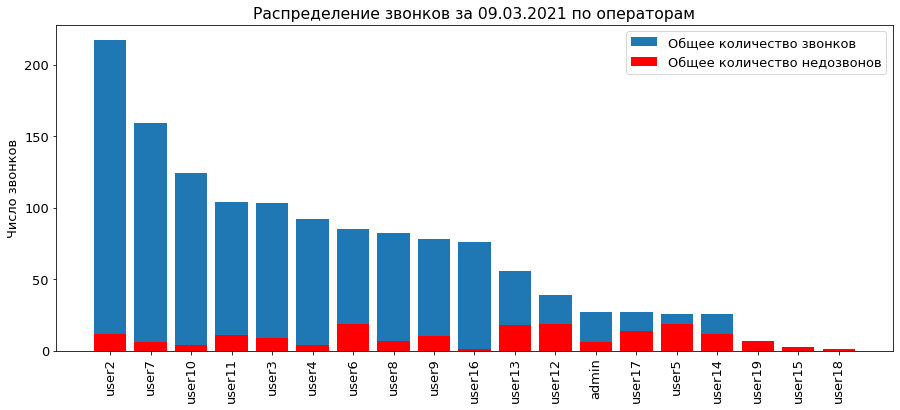

In [11]:
t1=total_all_days[(total_all_days['Отчетная дата']==dt.date(2021,3,10))]
                  #& (total_all_days['Тип']=='vmk')]

tmp=t1.groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков").sort_values('Число звонков',ascending=False)

tmp2=t1[t1['Статус звонка']=='Не дождался'].groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков")

f = plt.figure(figsize=(15,6))
plt.bar(tmp['Оператор'], tmp['Число звонков'],label='Общее количество звонков')
plt.bar(tmp2['Оператор'], tmp2['Число звонков'],label='Общее количество недозвонов',color='red')

plt.ylabel('Число звонков')
plt.title('Распределение звонков за 09.03.2021 по операторам')

plt.rcParams.update({'font.size': 13})
plt.gca().xaxis.set_tick_params(rotation = 90) 
plt.legend()
plt.show()

C:\Users\AdminIS\AppData\Local\Temp/ipykernel_10980/2287687475.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['Оператор']=tmp['Оператор'].fillna('Не определен')


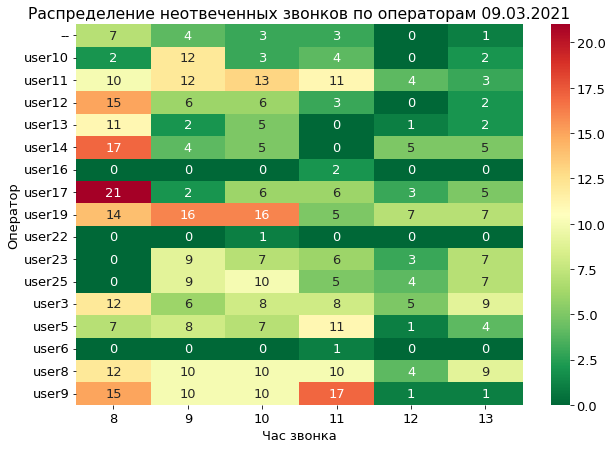

In [12]:
import seaborn as sns
tmp=total_all_days[ (total_all_days['Отчетная дата']==dt.date(2021,5,5))]
#tmp=total_all_days[ (total_all_days['Отчетная дата']==dt.date(2021,2,17))]
#(total_all_days['Тип']=='vmk')
                   #& (total_all_days['Статус звонка']!='Не дождался')]
tmp['Оператор']=tmp['Оператор'].fillna('Не определен')


f = plt.figure(figsize=(10,7))
heatmap_plot = sns.heatmap(pd.crosstab(tmp['Оператор'], tmp['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
plt.title('Распределение неотвеченных звонков по операторам 09.03.2021')

plt.show()

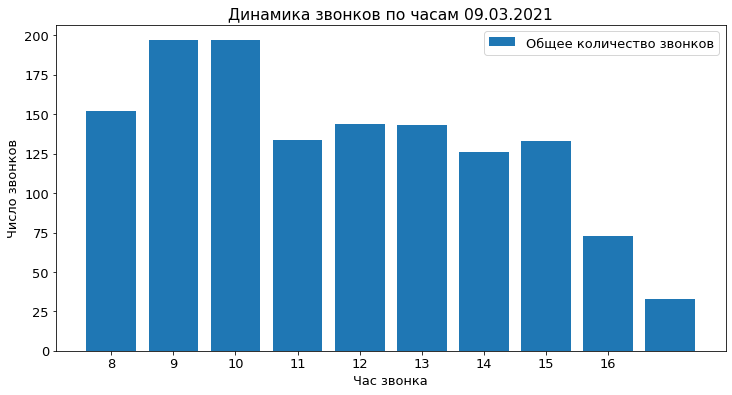

In [13]:
tmp=total_all_days[ (total_all_days['Отчетная дата']==dt.date(2021,3,10))].groupby('Час звонка')['Дата звонка'].count().reset_index(name="Число звонков")
#(total_all_days['Тип']=='vmk')
f = plt.figure(figsize=(12,6))
plt.bar(tmp['Час звонка'], tmp['Число звонков'],label='Общее количество звонков')

plt.xlabel('Час звонка')
plt.ylabel('Число звонков')
plt.title('Динамика звонков по часам 09.03.2021')

plt.rcParams.update({'font.size': 13})
plt.xticks(np.arange(8,17,1))
plt.legend()
plt.show()

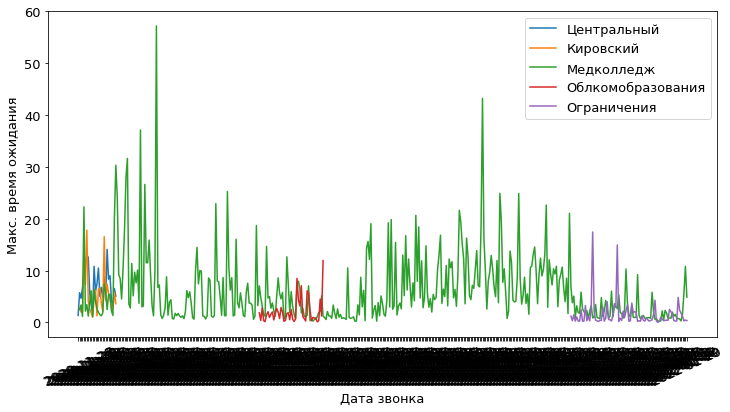

In [14]:
tmp=total_all_days[total_all_days['Тип']=='vmk'].groupby(['Дата звонка','Группа'])['Время ожидания'].max().reset_index(name="Макс. время ожидания")

f = plt.figure(figsize=(12,6))

for name in tmp['Группа'].unique()[6:]:
    
    tmp2=tmp[tmp['Группа']==name]
    plt.plot(tmp2['Дата звонка'], tmp2['Макс. время ожидания'],label=name)

    
plt.xlabel('Дата звонка')
plt.ylabel('Макс. время ожидания')
#plt.title('Динамика максимального времени ожидания')

plt.rcParams.update({'font.size': 13})
plt.xticks(pd.date_range(start=tmp['Дата звонка'].min(), end=tmp['Дата звонка'].max()))
plt.rcParams.update({'font.size': 13})
plt.gca().xaxis.set_tick_params(rotation = 25) 
plt.legend()
plt.show()

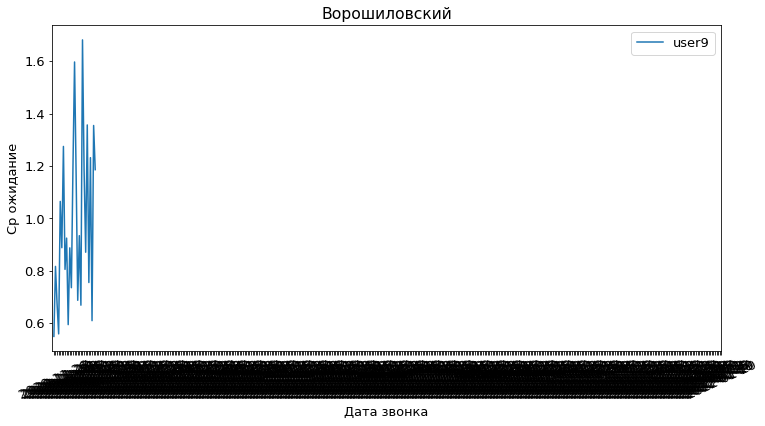

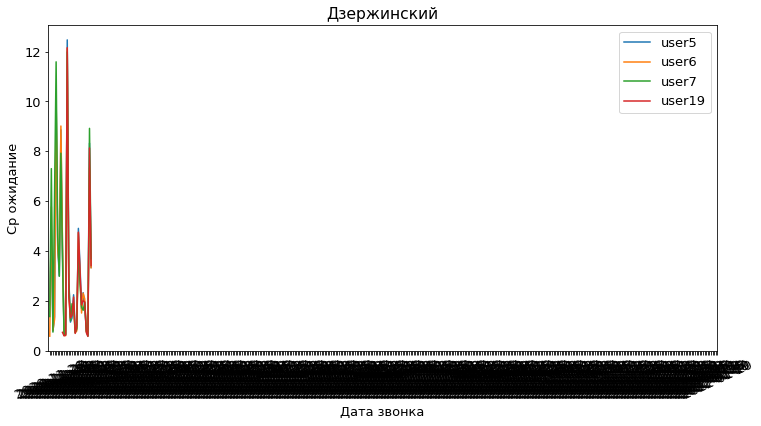

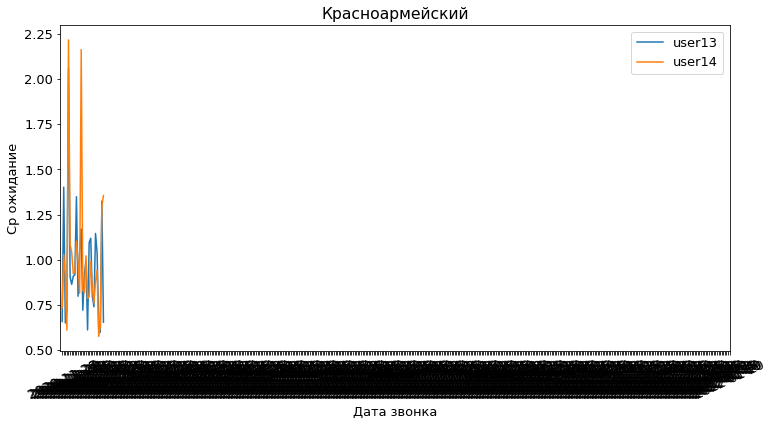

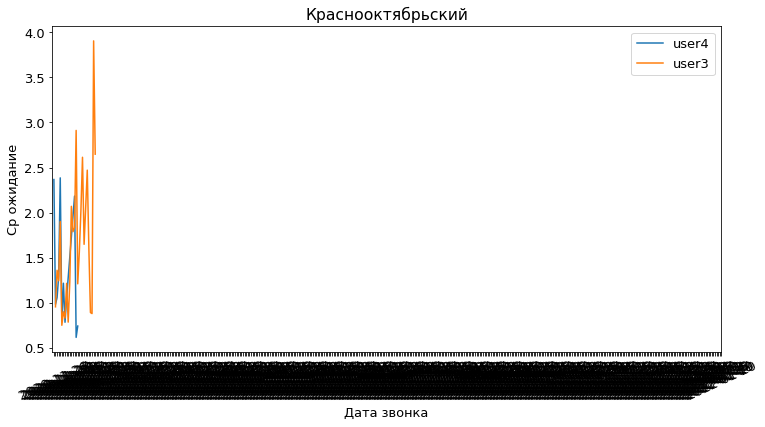

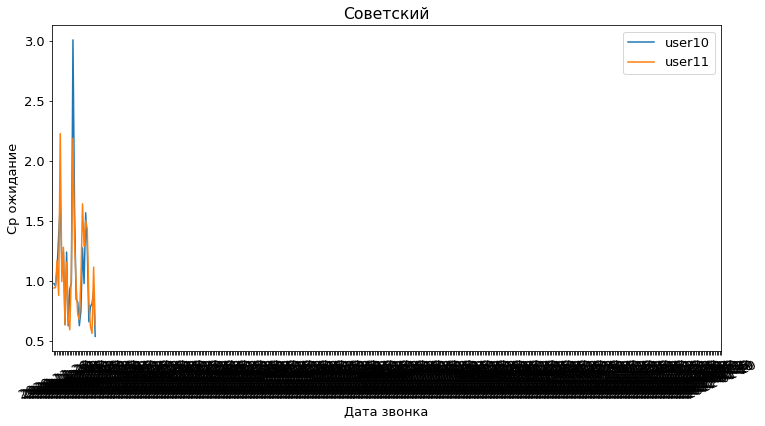

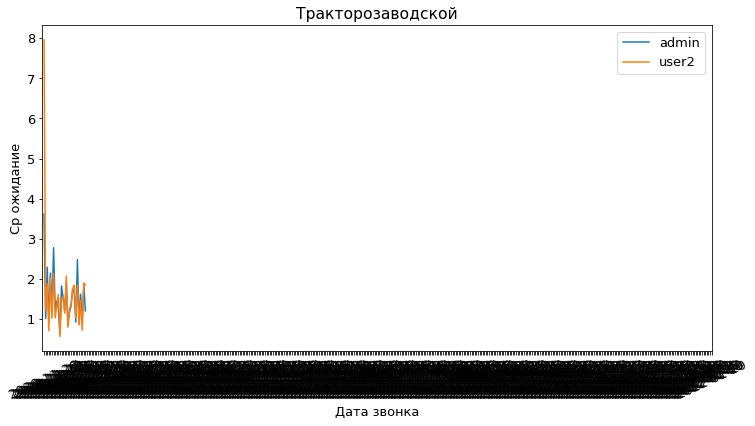

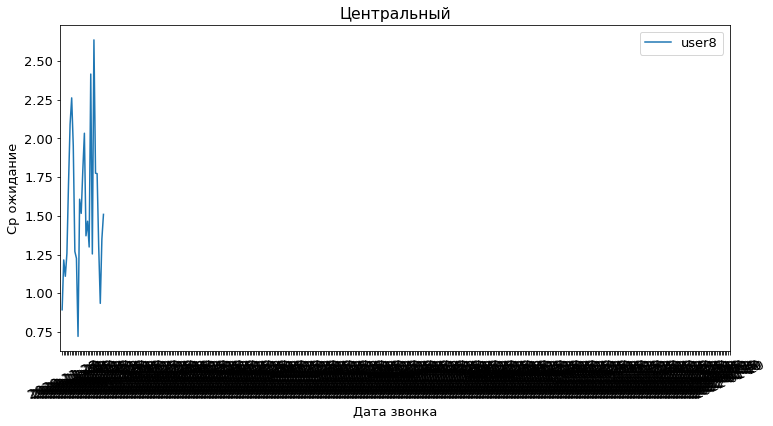

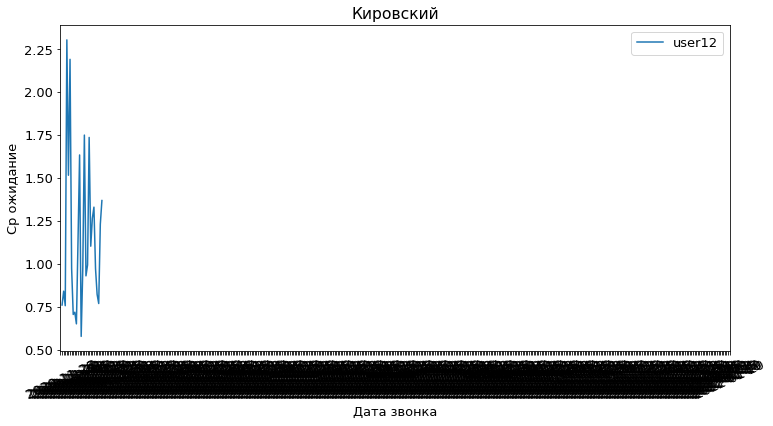

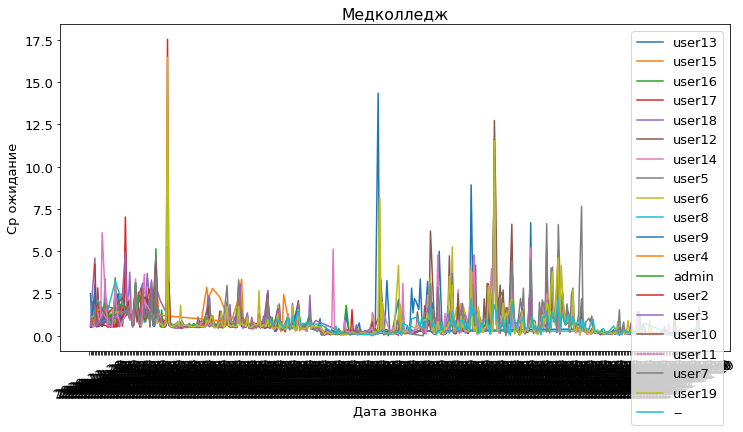

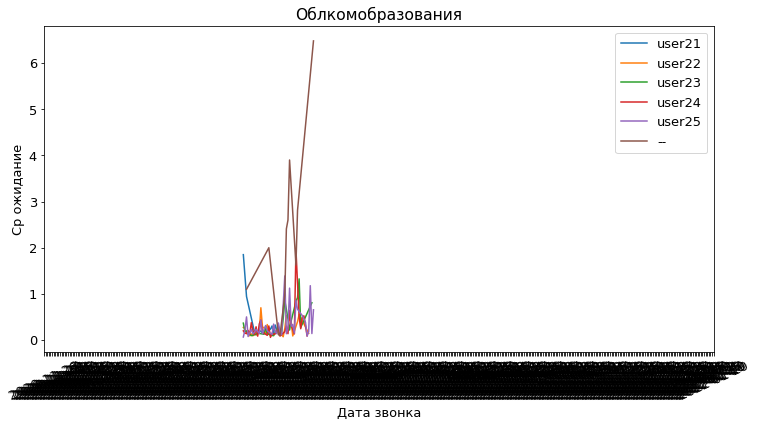

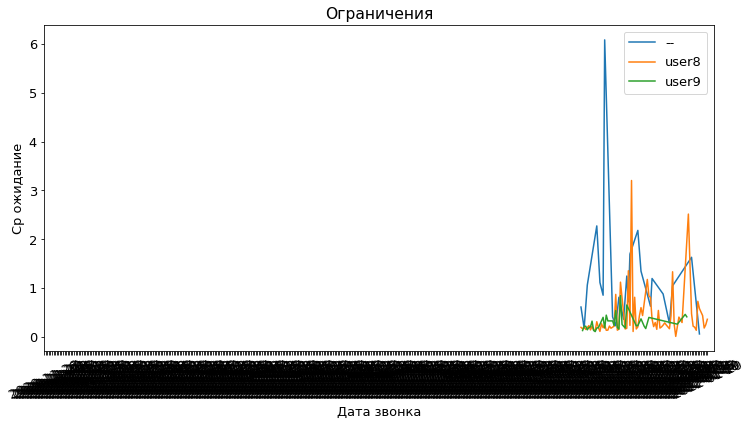

In [15]:
tmp=total_all_days[total_all_days['Тип']=='vmk']
tmp=tmp.groupby(['Дата звонка','Группа','Оператор'])['Время ожидания'].mean().reset_index(name="Ср ожидание")

for name in tmp['Группа'].unique():
    f = plt.figure(figsize=(12,6))
    tmp2=tmp[tmp['Группа']==name]
    for op in tmp2['Оператор'].unique():
        tmp3=tmp2[tmp2['Оператор']==op]
        plt.plot(tmp3['Дата звонка'], tmp3['Ср ожидание'],label=op)

    
    plt.xlabel('Дата звонка')
    plt.ylabel('Ср ожидание')
    plt.title(name)

    plt.rcParams.update({'font.size': 13})
    plt.xticks(pd.date_range(start=tmp['Дата звонка'].min(), end=tmp['Дата звонка'].max()))
    plt.rcParams.update({'font.size': 13})
    plt.gca().xaxis.set_tick_params(rotation = 25) 
    plt.legend()
    plt.show()

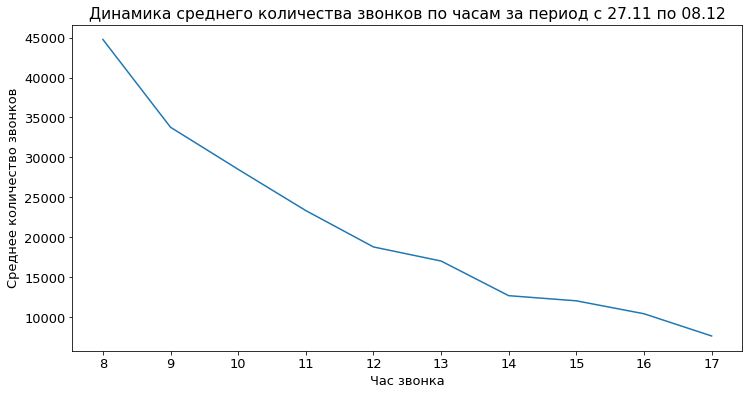

In [16]:
tmp=total_all_days[total_all_days['Тип']=='vmk']
tmp=tmp.groupby(['Час звонка'])['Время ожидания'].count().reset_index(name='Количество звонков')
tmp['Количество звонков']=tmp['Количество звонков']

f = plt.figure(figsize=(12,6))
plt.plot(tmp['Час звонка'], tmp['Количество звонков'])

    
plt.xlabel('Час звонка')
plt.ylabel('Среднее количество звонков')
plt.title('Динамика среднего количества звонков по часам за период с 27.11 по 08.12')

plt.rcParams.update({'font.size': 13})
plt.xticks(np.arange(8,18,1))
#plt.legend()
plt.show()

In [17]:
tmp=total[total['Тип']=='vmk'].groupby('Статус звонка')['Дата звонка'].count().reset_index(name="Число звонков")

f = plt.figure(figsize=(10,6))
explode = (0, 0, 0.1)
plt.pie(tmp['Число звонков'],labels=tmp['Статус звонка'],autopct='%1.1f%%',colors=['lightblue','lightgreen','red'],explode=explode)

plt.title('Распределение статусов вызовов по операторам ВМК')
plt.rcParams.update({'font.size': 15})
plt.show()

NameError: name 'total' is not defined

In [ ]:
temp=total_all_days[(total_all_days['Тип']=='vmk') & (total_all_days['Отчетная дата']==dt.date.today())][['Группа','Оператор','Время ожидания','Время звонка']]
temp['Оператор']=temp['Оператор'].fillna('Не определен')

t1=temp.groupby(['Группа','Оператор'])['Время звонка'].count().reset_index(name="Число звонков")
t2=temp.groupby(['Группа','Оператор'])['Время ожидания'].mean().round(1).reset_index(name="Среднее время ожидания (мин)")
t3=temp.groupby(['Группа','Оператор'])['Время ожидания'].max().round(1).reset_index(name="Максимальное время ожидания (мин)")

rez=t1.merge(t2).merge(t3)
rez=rez.sort_values(by='Число звонков',ascending=False)
#rez.to_excel('Операторы '+date_for_statistics+'.xlsx' )
#temp.info()

##### 